<h1>An exploration of English cities

<h3>Set up all the libraries

In [1]:
!pip install geopy

In [1]:
#make sure all the libraries are imported
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [3]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="My England explorer")

<h3>
    Set up credentials and venue function for FourSquare

In [2]:
CLIENT_ID = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx' # Foursquare ID
CLIENT_SECRET = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx' # Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT=100

In [3]:
#Clean FourSquare data and reduce categories
def convert_the_name(the_name):
    if(the_name in ["Sandwich Place", "Pizza Place", "Steakhouse", "Burger Joint", "Pie Shop", "Snack Place"]):
        return "Fast Food" 
    if("Joint" in the_name):
        return "Fast Food"
    if("Station" in the_name):
        return "Station"
    if(the_name=="Coffee Shop"):
        return "Café"
    if("Store" in the_name):
        return "Store"
    if("Restaurant" in the_name):
        return "Restaurant"
    if("Art" in the_name):
        return "Art"
    if("Museum" in the_name):
        return "Art"
    if("Bar" in the_name):
        return "Bar"
    if("Auto" in the_name):
        return "Auto shop"
    if("Soccer" in the_name):
        return "Stadium"
    if("Rugby" in the_name):
        return "Stadium"
    if("Theme Park" in the_name):
        return "Theme Park"
    #nothing
    return the_name
    
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            convert_the_name(v['venue']['categories'][0]['name'])) for v in results])
        
        total_results=0
        for v in results:
            total_results=total_results+1
          
        no_venue_index=0
        while(total_results)<20:
            no_venue_name='no_venue'+str(no_venue_index)
            no_venue_index=no_venue_index+1
            venues_list.append([(
            name, 
            lat, 
            lng, 
            no_venue_name, 
            0, 
            0,  
            no_venue_name)])
            total_results=total_results+1
                     
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [125]:
#Test geolocator and FourSquare
#location = geolocator.geocode("Stoke-on-Trent, UK", timeout=10000)
#print(location.address)
#print((location.latitude, location.longitude))
#getNearbyVenues(names="Stoke-on-Trent, UK",latitudes=[location.latitude], longitudes=[location.longitude])

<h2>Get city and town data from website

In [4]:
url = 'https://www.thegeographist.com/uk-cities-population-1000'
#convert html list to dataframe
df_table = pd.read_html(url)
df_uk_towns_cities_table=df_table[0]
df_uk_towns_cities_table.head()

,Rank,in region,City/Town,Ceremonial county,Unnamed: 4,Region,Population
0,1,1,London,London,NaN,London,8907918.0
1,2,1,Birmingham,West Midlands,NaN,West Midlands,1153717.0
2,3,1,Glasgow,Glasgow,NaN,Scotland,612040.0
3,4,1,Liverpool,Merseyside,NaN,North West,579256.0
4,5,1,Bristol,Bristol,NaN,South West,571922.0


<h2>Clean data

In [5]:
df_england=df_uk_towns_cities_table[~df_uk_towns_cities_table.Region.isin(['Scotland','Wales','Northern Ireland'])]
df_england

,Rank,in region,City/Town,Ceremonial county,Unnamed: 4,Region,Population
0,1,1,London,London,NaN,London,8907918.000
1,2,1,Birmingham,West Midlands,NaN,West Midlands,1153717.000
3,4,1,Liverpool,Merseyside,NaN,North West,579256.000
4,5,1,Bristol,Bristol,NaN,South West,571922.000
5,6,2,Manchester,Greater Manchester,NaN,North West,554400.000
6,7,1,Sheffield,South Yorkshire,NaN,Yorkshire Humber,544402.000
7,8,2,Leeds,West Yorkshire,NaN,Yorkshire Humber,503388.000
9,10,1,Leicester,Leicestershire,NaN,East Midlands,470965.000
10,11,2,Coventry,West Midlands,NaN,West Midlands,369127.000
11,12,3,Bradford,West Yorkshire,NaN,Yorkshire Humber,361046.000


Add latitudes and longitudes and remove unnecessary columns

In [7]:
df_england_localities=df_england[["City/Town", "Ceremonial county"]].copy()

In [8]:
df_england_localities["latitude"]=""
df_england_localities["longitude"]=""

In [9]:
df_england_localities

,City/Town,Ceremonial county,latitude,longitude
0,London,London,,
1,Birmingham,West Midlands,,
3,Liverpool,Merseyside,,
4,Bristol,Bristol,,
5,Manchester,Greater Manchester,,
6,Sheffield,South Yorkshire,,
7,Leeds,West Yorkshire,,
9,Leicester,Leicestershire,,
10,Coventry,West Midlands,,
11,Bradford,West Yorkshire,,


Correct incorrect town names in table

In [13]:

df_england_localities.loc[df_england_localities["City/Town"]=="Corsett","City/Town"]="Consett"
df_england_localities.loc[df_england_localities["City/Town"]=="Gerrards CrossChalfont St Peter","City/Town"]="Chalfont St Peter, Gerrards Cross"
df_england_localities.loc[df_england_localities["City/Town"]=="HartleyLongfield","City/Town"]="Hartley Longfield"
df_england_localities.loc[df_england_localities["City/Town"]=="Frampton CotterellWinterbourne","City/Town"]="Frampton Cotterell, Winterbourne"
df_england_localities.loc[df_england_localities["City/Town"]=="Whittlesley","City/Town"]="Whittlesey, Fenland"
df_england_localities.loc[df_england_localities["City/Town"]=="Desbrorough","City/Town"]="Desborough"
df_england_localities.loc[df_england_localities["City/Town"]=="Ferryhill","City/Town"]="Ferryhill, County Durham"
df_england_localities.loc[df_england_localities["City/Town"]=="Stanley","City/Town"]="Stanley, County Durham"

In [26]:
from time import sleep
for index, row in df_england_localities.iterrows():
    if index>-1:
        location_name=row["City/Town"]+", "+row["Ceremonial County"]+", UK"
        print(location_name)
        location = geolocator.geocode(location_name, timeout=100000)
        print(location)
        df_england_localities.at[index,'latitude']=location.latitude
        df_england_localities.at[index,'longitude']=location.longitude
        print(index, row)
        # slow down for geolocator
        sleep(1)


Birmingham, UK
Birmingham, West Midlands Combined Authority, West Midlands, England, United Kingdom
1 City/Town               Birmingham
Ceremonial county    West Midlands
latitude                   52.4797
longitude                 -1.90269
Name: 1, dtype: object
Liverpool, UK
Liverpool, North West England, England, United Kingdom
3 City/Town             Liverpool
Ceremonial county    Merseyside
latitude                53.4072
longitude              -2.99166
Name: 3, dtype: object
Bristol, UK
Bristol, City of Bristol, South West England, England, United Kingdom
4 City/Town            Bristol
Ceremonial county    Bristol
latitude             51.4538
longitude            -2.5973
Name: 4, dtype: object
Manchester, UK
Manchester, Greater Manchester, North West England, England, United Kingdom
5 City/Town                    Manchester
Ceremonial county    Greater Manchester
latitude                        53.4795
longitude                      -2.24511
Name: 5, dtype: object
Sheffield, UK


Wigan, UK
Wigan, Greater Manchester, North West England, England, United Kingdom
76 City/Town                         Wigan
Ceremonial county    Greater Manchester
latitude                        53.5457
longitude                      -2.62646
Name: 76, dtype: object
Lincoln, UK
Lincoln, Lincolnshire, East Midlands, England, United Kingdom
77 City/Town                 Lincoln
Ceremonial county    Lincolnshire
latitude                  53.2336
longitude               -0.539217
Name: 77, dtype: object
Oldham, UK
Oldham, Greater Manchester, North West England, England, United Kingdom
78 City/Town                        Oldham
Ceremonial county    Greater Manchester
latitude                        53.5416
longitude                      -2.11478
Name: 78, dtype: object
Wakefield, UK
Wakefield, Yorkshire and the Humber, England, United Kingdom
79 City/Town                 Wakefield
Ceremonial county    West Yorkshire
latitude                     53.683
longitude                  -1.49673
Nam

Burnley, UK
Burnley, Lancashire, North West England, England, United Kingdom
110 City/Town               Burnley
Ceremonial county    Lancashire
latitude                53.7907
longitude              -2.24392
Name: 110, dtype: object
Eastleigh, UK
Eastleigh, West End Road, Bitterne, Southampton, South East, England, SO18 6TW, United Kingdom
111 City/Town            Eastleigh
Ceremonial county    Hampshire
latitude               50.9202
longitude             -1.29928
Name: 111, dtype: object
Mansfield, UK
Mansfield, Nottinghamshire, East Midlands, England, United Kingdom
112 City/Town                  Mansfield
Ceremonial county    Nottinghamshire
latitude                     53.1448
longitude                   -1.19734
Name: 112, dtype: object
Chatham, UK
Chatham, South East, England, United Kingdom
113 City/Town             Chatham
Ceremonial county        Kent
latitude              51.3805
longitude            0.529276
Name: 113, dtype: object
Bury, UK
Bury St Edmunds, Suffolk, East 

Dewsbury, UK
Dewsbury, Yorkshire and the Humber, England, WF13 1LH, United Kingdom
145 City/Town                  Dewsbury
Ceremonial county    West Yorkshire
latitude                    53.6909
longitude                  -1.63021
Name: 145, dtype: object
Loughborough, UK
Loughborough, Leicestershire, East Midlands, England, LE11 5BJ, United Kingdom
146 City/Town              Loughborough
Ceremonial county    Leicestershire
latitude                    52.7724
longitude                   -1.2078
Name: 146, dtype: object
Margate, UK
Margate, Kent, South East, England, United Kingdom
148 City/Town            Margate
Ceremonial county       Kent
latitude             51.3894
longitude            1.38215
Name: 148, dtype: object
Stourbridge, UK
Stourbridge, West Midlands Combined Authority, West Midlands, England, DY8 1DN, United Kingdom
149 City/Town              Stourbridge
Ceremonial county    West Midlands
latitude                   52.4578
longitude                 -2.14743
Name: 149, d

Folkestone, UK
Folkestone, Kent, South East, England, CT20 1RZ, United Kingdom
185 City/Town            Folkestone
Ceremonial county          Kent
latitude                51.0791
longitude               1.17941
Name: 185, dtype: object
Smethwick, UK
Smethwick, West Midlands Combined Authority, West Midlands, England, B67 7QX, United Kingdom
186 City/Town                Smethwick
Ceremonial county    West Midlands
latitude                   52.4968
longitude                 -1.97392
Name: 186, dtype: object
Esher, UK
Esher, Surrey, South East, England, United Kingdom
187 City/Town               Esher
Ceremonial county      Surrey
latitude              51.3694
longitude           -0.365441
Name: 187, dtype: object
Sittingbourne, UK
Sittingbourne, Kent, South East, England, ME10 4AL, United Kingdom
188 City/Town            Sittingbourne
Ceremonial county             Kent
latitude                   51.3397
longitude                 0.734232
Name: 188, dtype: object
Wellingborough, UK
Welli

Hatfield, UK
Hatfield, Hertfordshire, East of England, England, AL10 0JY, United Kingdom
228 City/Town                 Hatfield
Ceremonial county    Hertfordshire
latitude                   51.7635
longitude                -0.225874
Name: 228, dtype: object
Wallsend, UK
Wallsend, Tyne and Wear, North East England, England, NE28 8HU, United Kingdom
231 City/Town                 Wallsend
Ceremonial county    Tyne and Wear
latitude                   54.9912
longitude                  -1.5342
Name: 231, dtype: object
Tipton, UK
Tipton, West Midlands Combined Authority, West Midlands, England, DY4 8ES, United Kingdom
232 City/Town                   Tipton
Ceremonial county    West Midlands
latitude                    52.529
longitude                 -2.06937
Name: 232, dtype: object
Grantham, UK
Grantham, Lincolnshire, East Midlands, England, United Kingdom
233 City/Town                Grantham
Ceremonial county    Lincolnshire
latitude                  52.9134
longitude               -0.64

Arnold, UK
Arnold, Nottinghamshire, East Midlands, England, NG5 7FT, United Kingdom
266 City/Town                     Arnold
Ceremonial county    Nottinghamshire
latitude                     53.0053
longitude                   -1.12555
Name: 266, dtype: object
Newark-on-Trent, UK
Newark on Trent, Nottinghamshire, East Midlands, England, NG24 1EJ, United Kingdom
267 City/Town            Newark-on-Trent
Ceremonial county    Nottinghamshire
latitude                     53.0762
longitude                  -0.809234
Name: 267, dtype: object
Long Eaton, UK
Long Eaton, Derbyshire, East Midlands, England, United Kingdom
268 City/Town            Long Eaton
Ceremonial county    Derbyshire
latitude                52.8986
longitude              -1.27081
Name: 268, dtype: object
Aldridge, UK
Aldridge, West Midlands Combined Authority, West Midlands, England, WS9 8LT, United Kingdom
269 City/Town                 Aldridge
Ceremonial county    West Midlands
latitude                    52.604
longitude 

Romiley, UK
Romiley, Stockport, Greater Manchester, North West England, England, SK6 3AN, United Kingdom
303 City/Town                       Romiley
Ceremonial county    Greater Manchester
latitude                        53.4141
longitude                      -2.09608
Name: 303, dtype: object
Spalding, UK
Spalding, Lincolnshire, East Midlands, England, United Kingdom
304 City/Town                Spalding
Ceremonial county    Lincolnshire
latitude                  52.7875
longitude               -0.151627
Name: 304, dtype: object
Bridlington, UK
Bridlington, East Riding of Yorkshire, Yorkshire and the Humber, England, YO16 4LF, United Kingdom
305 City/Town                         Bridlington
Ceremonial county    East Riding of Yorkshire
latitude                              54.0871
longitude                           -0.196451
Name: 305, dtype: object
Hucknall, UK
Hucknall, Nottinghamshire, East Midlands, England, NG15 7BA, United Kingdom
306 City/Town                   Hucknall
Ceremon

Sevenoaks, UK
Sevenoaks, Kent, South East, England, United Kingdom
338 City/Town            Sevenoaks
Ceremonial county         Kent
latitude               51.2745
longitude             0.196117
Name: 338, dtype: object
Sedgley, UK
Sedgley, Dudley, West Midlands Combined Authority, West Midlands, England, DY3 1US, United Kingdom
339 City/Town                  Sedgley
Ceremonial county    West Midlands
latitude                   52.5417
longitude                  -2.1211
Name: 339, dtype: object
Radcliffe, UK
Radcliffe, Greater Manchester, North West England, England, M26 1AD, United Kingdom
340 City/Town                     Radcliffe
Ceremonial county    Greater Manchester
latitude                        53.5593
longitude                      -2.32615
Name: 340, dtype: object
Bedworth, UK
Bedworth, Warwickshire, West Midlands, England, CV12 9DQ, United Kingdom
341 City/Town                Bedworth
Ceremonial county    Warwickshire
latitude                  52.4793
longitude            

Stretford, UK
Stretford, Greater Manchester, North West England, England, M32 9DF, United Kingdom
382 City/Town                     Stretford
Ceremonial county    Greater Manchester
latitude                        53.4454
longitude                      -2.32231
Name: 382, dtype: object
Darwen, UK
Darwen, Blackburn with Darwen, North West England, England, BB3 1BH, United Kingdom
383 City/Town                Darwen
Ceremonial county    Lancashire
latitude                53.6961
longitude              -2.46651
Name: 383, dtype: object
Melton Mowbray, UK
Melton Mowbray, Leicestershire, East Midlands, England, LE13 0TT, United Kingdom
384 City/Town            Melton Mowbray
Ceremonial county    Leicestershire
latitude                     52.765
longitude                 -0.887587
Name: 384, dtype: object
Evesham, UK
Evesham, Worcestershire, West Midlands, England, WR11, United Kingdom
385 City/Town                   Evesham
Ceremonial county    Worcestershire
latitude                     5

Swinton, UK
Swinton, Yorkshire and the Humber, England, S64 8HW, United Kingdom
419 City/Town                       Swinton
Ceremonial county    Greater Manchester
latitude                        53.4865
longitude                      -1.32579
Name: 419, dtype: object
Oldbury, UK
Oldbury, West Midlands Combined Authority, West Midlands, England, B69 2AB, United Kingdom
420 City/Town                  Oldbury
Ceremonial county    West Midlands
latitude                   52.5039
longitude                 -2.01639
Name: 420, dtype: object
Market Harborough, UK
Market Harborough, Leicestershire, East Midlands, England, LE16 7PA, United Kingdom
421 City/Town            Market Harborough
Ceremonial county       Leicestershire
latitude                       52.4777
longitude                    -0.920857
Name: 421, dtype: object
Bishop Auckland, UK
Bishop Auckland, Escomb Road, Bishop Auckland, County Durham, North East England, England, DL14 6AA, United Kingdom
422 City/Town            Bishop 

Potters Bar, UK
Potters Bar, Hertfordshire, East of England, England, EN6 2BD, United Kingdom
455 City/Town              Potters Bar
Ceremonial county    Hertfordshire
latitude                   51.7026
longitude                -0.195565
Name: 455, dtype: object
Seaford, UK
Seaford, East Sussex, South East, England, United Kingdom
456 City/Town                Seaford
Ceremonial county    East Sussex
latitude                 50.7783
longitude                0.11048
Name: 456, dtype: object
Sudbury, UK
Sudbury, Suffolk, East of England, England, CO10 1GL, United Kingdom
457 City/Town            Sudbury
Ceremonial county    Suffolk
latitude             52.0402
longitude            0.72995
Name: 457, dtype: object
Godalming, UK
Godalming, Waverley, Surrey, South East, England, United Kingdom
458 City/Town            Godalming
Ceremonial county       Surrey
latitude               51.1889
longitude             -0.61122
Name: 458, dtype: object
Reigate, UK
Reigate, Surrey, South East, England

March, UK
March, Cambridgeshire, East of England, England, United Kingdom
490 City/Town                     March
Ceremonial county    Cambridgeshire
latitude                    52.5496
longitude                  0.088127
Name: 490, dtype: object
Kenilworth, UK
Kenilworth, Warwickshire, West Midlands, England, CV8 1NJ, United Kingdom
491 City/Town              Kenilworth
Ceremonial county    Warwickshire
latitude                  52.3451
longitude                 -1.5816
Name: 491, dtype: object
Gatley, UK
Gatley, Greater Manchester, North West England, England, SK8 4PD, United Kingdom
492 City/Town                        Gatley
Ceremonial county    Greater Manchester
latitude                        53.3911
longitude                      -2.22847
Name: 492, dtype: object
Berkhamsted, UK
Berkhamsted, Dacorum, Hertfordshire, East of England, England, United Kingdom
493 City/Town              Berkhamsted
Ceremonial county    Hertfordshire
latitude                   51.7551
longitude      

Portslade-by-Sea, UK
Portslade by Sea, South East, England, BN3 4EL, United Kingdom
527 City/Town            Portslade-by-Sea
Ceremonial county         East Sussex
latitude                       50.833
longitude                   -0.207021
Name: 527, dtype: object
Tiverton, UK
Tiverton, Devon, South West England, England, EX16 6PD, United Kingdom
528 City/Town            Tiverton
Ceremonial county       Devon
latitude              50.9027
longitude            -3.48919
Name: 528, dtype: object
Peacehaven, UK
Peacehaven, Lewes, East Sussex, South East, England, United Kingdom
529 City/Town             Peacehaven
Ceremonial county    East Sussex
latitude                  50.797
longitude             0.00689554
Name: 529, dtype: object
Ware, UK
Ware, Hertfordshire, East of England, England, SG12 9XB, United Kingdom
530 City/Town                     Ware
Ceremonial county    Hertfordshire
latitude                   51.8103
longitude               -0.0328751
Name: 530, dtype: object
Earl Shi

Colne, UK
Colne, Leach Street, Colne, Pendle, Lancashire, North West England, England, BB8 9NS, United Kingdom
563 City/Town                 Colne
Ceremonial county    Lancashire
latitude                53.8549
longitude              -2.18189
Name: 563, dtype: object
Failsworth, UK
Failsworth, Greater Manchester, North West England, England, M35 9DU, United Kingdom
565 City/Town                    Failsworth
Ceremonial county    Greater Manchester
latitude                         53.515
longitude                      -2.15003
Name: 565, dtype: object
Mansfield Woodhouse, UK
Mansfield Woodhouse, Mansfield, Nottinghamshire, East Midlands, England, NG19 8BH, United Kingdom
567 City/Town            Mansfield Woodhouse
Ceremonial county        Nottinghamshire
latitude                         53.1675
longitude                       -1.18863
Name: 567, dtype: object
Cobham, UK
Cobham, Surrey, South East, England, United Kingdom
568 City/Town              Cobham
Ceremonial county      Surrey
l

Bedlington, UK
Bedlington, Northumberland, North East England, England, NE22 6JX, United Kingdom
604 City/Town                Bedlington
Ceremonial county    Northumberland
latitude                    55.1324
longitude                  -1.59808
Name: 604, dtype: object
Brixham, UK
Brixham, South West England, England, TQ5 8EP, United Kingdom
606 City/Town            Brixham
Ceremonial county      Devon
latitude             50.3952
longitude           -3.51454
Name: 606, dtype: object
Cirencester, UK
Cirencester, Gloucestershire, South West England, England, GL7, United Kingdom
607 City/Town                Cirencester
Ceremonial county    Gloucestershire
latitude                      51.717
longitude                   -1.96853
Name: 607, dtype: object
Royston, UK
Royston, Hertfordshire, East of England, England, SG8 9FG, United Kingdom
609 City/Town                  Royston
Ceremonial county    Hertfordshire
latitude                   52.0473
longitude               -0.0246467
Name: 609

Bodmin, UK
Bodmin, Cornwall, South West England, England, PL31 1JU, United Kingdom
648 City/Town              Bodmin
Ceremonial county    Cornwall
latitude              50.4707
longitude            -4.72432
Name: 648, dtype: object
Matlock, UK
Matlock, Derbyshire, East Midlands, England, DE4 3AR, United Kingdom
649 City/Town               Matlock
Ceremonial county    Derbyshire
latitude                53.1375
longitude              -1.55447
Name: 649, dtype: object
Tadley, UK
Tadley, Basingstoke and Deane, Hampshire, South East, England, United Kingdom
650 City/Town               Tadley
Ceremonial county    Hampshire
latitude               51.3414
longitude             -1.14468
Name: 650, dtype: object
Teignmouth, UK
Teignmouth, Devon, South West England, England, TQ14 8AJ, United Kingdom
651 City/Town            Teignmouth
Ceremonial county         Devon
latitude                50.5463
longitude              -3.49582
Name: 651, dtype: object
Knaresborough, UK
Knaresborough, North York

Chertsey, UK
Chertsey, Surrey, South East, England, United Kingdom
695 City/Town            Chertsey
Ceremonial county      Surrey
latitude              51.3923
longitude           -0.503829
Name: 695, dtype: object
Yateley, UK
Yateley, Hart, Hampshire, South East, England, United Kingdom
697 City/Town              Yateley
Ceremonial county    Hampshire
latitude                51.337
longitude            -0.816597
Name: 697, dtype: object
Armthorpe, UK
Armthorpe, Yorkshire and the Humber, England, DN3 2DA, United Kingdom
699 City/Town                  Armthorpe
Ceremonial county    South Yorkshire
latitude                     53.5395
longitude                    -1.0599
Name: 699, dtype: object
Cowes, UK
Cowes, Isle of Wight, South East, England, United Kingdom
700 City/Town                    Cowes
Ceremonial county    Isle of Wight
latitude                   50.7576
longitude                 -1.30356
Name: 700, dtype: object
Knottingley, UK
Knottingley, Yorkshire and the Humber, Engl

Bridport, UK
Bridport, Dorset, South West England, England, United Kingdom
741 City/Town            Bridport
Ceremonial county      Dorset
latitude              50.7338
longitude             -2.7589
Name: 741, dtype: object
Alsager, UK
Alsager, Cheshire East, North West England, England, ST7 2LP, United Kingdom
744 City/Town             Alsager
Ceremonial county    Cheshire
latitude              53.0961
longitude            -2.30463
Name: 744, dtype: object
Midsomer Norton, UK
Midsomer Norton, Bath and North East Somerset, South West England, England, BA3 2, United Kingdom
745 City/Town            Midsomer Norton
Ceremonial county           Somerset
latitude                     51.2857
longitude                   -2.47715
Name: 745, dtype: object
Birstall, UK
Birstall, Charnwood, Leicestershire, East Midlands, England, United Kingdom
746 City/Town                  Birstall
Ceremonial county    Leicestershire
latitude                    52.6788
longitude                  -1.12447
Name: 

Heckmondwike, UK
Heckmondwike, Yorkshire and the Humber, England, WF16 0EY, United Kingdom
786 City/Town              Heckmondwike
Ceremonial county    West Yorkshire
latitude                    53.7074
longitude                  -1.67545
Name: 786, dtype: object
New Mills, UK
New Mills, Derbyshire, East Midlands, England, SK22 3BN, United Kingdom
788 City/Town             New Mills
Ceremonial county    Derbyshire
latitude                53.3654
longitude              -2.00128
Name: 788, dtype: object
Mablethorpe, UK
Mablethorpe, Lincolnshire, East Midlands, England, United Kingdom
789 City/Town             Mablethorpe
Ceremonial county    Lincolnshire
latitude                  53.3408
longitude                0.260677
Name: 789, dtype: object
Little Lever, UK
Little Lever, Greater Manchester, North West England, England, BL3 1HG, United Kingdom
790 City/Town                  Little Lever
Ceremonial county    Greater Manchester
latitude                        53.5622
longitude         

Featherstone, UK
Featherstone, Yorkshire and the Humber, England, WF7 5BD, United Kingdom
831 City/Town              Featherstone
Ceremonial county    West Yorkshire
latitude                    53.6777
longitude                  -1.35827
Name: 831, dtype: object
Henley-on-Thames, UK
Henley-on-Thames, Oxfordshire, South East, England, RG9 2AN, United Kingdom
833 City/Town            Henley-on-Thames
Ceremonial county         Oxfordshire
latitude                      51.5376
longitude                   -0.905029
Name: 833, dtype: object
Woodbridge, UK
Woodbridge, Suffolk, East of England, England, IP12 1AJ, United Kingdom
834 City/Town            Woodbridge
Ceremonial county       Suffolk
latitude                52.0941
longitude               1.32013
Name: 834, dtype: object
Gillingham, UK
Gillingham, South East, England, United Kingdom
837 City/Town            Gillingham
Ceremonial county        Dorset
latitude                51.3877
longitude              0.545771
Name: 837, dtype: ob

Kingsteignton, UK
Kingsteignton, Devon, South West England, England, TQ12 3LL, United Kingdom
876 City/Town            Kingsteignton
Ceremonial county            Devon
latitude                   50.5496
longitude                 -3.59557
Name: 876, dtype: object
Great Harwood, UK
Great Harwood, Lancashire, North West England, England, BB6 7NN, United Kingdom
877 City/Town            Great Harwood
Ceremonial county       Lancashire
latitude                   53.7867
longitude                 -2.40675
Name: 877, dtype: object
Hoylake, UK
Hoylake, North West England, England, CH47 2BF, United Kingdom
878 City/Town               Hoylake
Ceremonial county    Merseyside
latitude                53.3923
longitude              -3.17819
Name: 878, dtype: object
Annfield Plain, UK
Annfield Plain, County Durham, North East England, England, DH9 7XT, United Kingdom
879 City/Town            Annfield Plain
Ceremonial county     County Durham
latitude                    54.8578
longitude              

Cranleigh, UK
Cranleigh, Waverley, Surrey, South East, England, United Kingdom
918 City/Town            Cranleigh
Ceremonial county       Surrey
latitude               51.1356
longitude            -0.491717
Name: 918, dtype: object
Soham, UK
Soham, Cambridgeshire, East of England, England, United Kingdom
919 City/Town                     Soham
Ceremonial county    Cambridgeshire
latitude                    52.3333
longitude                  0.338747
Name: 919, dtype: object
Westergate, UK
Westergate, West Sussex, South East, England, United Kingdom
920 City/Town             Westergate
Ceremonial county    West Sussex
latitude                 50.8383
longitude              -0.669041
Name: 920, dtype: object
Radstock, UK
Radstock, Bath and North East Somerset, South West England, England, BA3 3, United Kingdom
922 City/Town            Radstock
Ceremonial county    Somerset
latitude              51.2919
longitude            -2.44762
Name: 922, dtype: object
Cambourne, UK
Cambourne, Cambri

Hemsworth, UK
Hemsworth, Yorkshire and the Humber, England, WF9 4QZ, United Kingdom
966 City/Town                 Hemsworth
Ceremonial county    West Yorkshire
latitude                    53.6132
longitude                  -1.36018
Name: 966, dtype: object
North Wingfield, UK
North Wingfield, Derbyshire, East Midlands, England, S42 5LH, United Kingdom
969 City/Town            North Wingfield
Ceremonial county         Derbyshire
latitude                     53.1807
longitude                   -1.38776
Name: 969, dtype: object
Sileby, UK
Sileby, Charnwood, Leicestershire, East Midlands, England, United Kingdom
972 City/Town                    Sileby
Ceremonial county    Leicestershire
latitude                    52.7384
longitude                  -1.10063
Name: 972, dtype: object
Worsbrough, UK
Worsbrough, Barnsley, Yorkshire and the Humber, England, S70 5AN, United Kingdom
974 City/Town                 Worsbrough
Ceremonial county    South Yorkshire
latitude                     53.5318


In [27]:
df_england_localities

,City/Town,Ceremonial county,latitude,longitude
0,London,London,51.5073,-0.127647
1,Birmingham,West Midlands,52.4797,-1.90269
3,Liverpool,Merseyside,53.4072,-2.99166
4,Bristol,Bristol,51.4538,-2.5973
5,Manchester,Greater Manchester,53.4795,-2.24511
6,Sheffield,South Yorkshire,53.3807,-1.47023
7,Leeds,West Yorkshire,53.7974,-1.54379
9,Leicester,Leicestershire,52.6361,-1.13308
10,Coventry,West Midlands,52.4082,-1.51048
11,Bradford,West Yorkshire,53.7944,-1.75192


Geolocator in often unstable and cannot be relied on to consistently process large amounts of data, so the following lines create a cache of the data so we don't have to keep using Geolocator each time!

In [10]:
#df_england_localities.to_csv (r'C:\Users\Marco\england_localities.csv', index = None, header=True)
df_england_localities1=pd.read_csv(r'C:\Users\Marco\england_localities.csv')
df_england_localities=df_england_localities1.iloc[0:300] #select the top 300 or so

In [11]:
df_england_localities

,City/Town,Ceremonial county,latitude,longitude
0,London,London,51.507322,-0.127647
1,Birmingham,West Midlands,52.479699,-1.902691
2,Liverpool,Merseyside,53.407154,-2.991665
3,Bristol,Bristol,51.453802,-2.597298
4,Manchester,Greater Manchester,53.479489,-2.245115
5,Sheffield,South Yorkshire,53.380663,-1.470228
6,Leeds,West Yorkshire,53.797419,-1.543794
7,Leicester,Leicestershire,52.636140,-1.133079
8,Coventry,West Midlands,52.408181,-1.510477
9,Bradford,West Yorkshire,53.794423,-1.751919


In [12]:
# create map of England using latitude and longitude values, start from the first neighbourhood
map_england = folium.Map(location=[52.4828, -1.6101], zoom_start=7)#centre of england

# add markers to map
for lat, lng, Locality in zip(df_england_localities['latitude'],
                              df_england_localities['longitude'],
                              df_england_localities['City/Town']):
    label = '{}'.format(Locality)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_england)  
    
map_england

In [13]:
england_venues = getNearbyVenues(names=df_england_localities['City/Town'],
                                   latitudes=df_england_localities['latitude'],
                                   longitudes=df_england_localities['longitude']
                                  )

London
Birmingham
Liverpool
Bristol
Manchester
Sheffield
Leeds
Leicester
Coventry
Bradford
Nottingham
Kingston upon Hull
Newcastle upon Tyne
Stoke-on-Trent
Southampton
Derby
Portsmouth
Brighton
Plymouth
Northampton
Reading
Luton
Wolverhampton
Bolton
Bournemouth
Norwich
Swindon
Milton Keynes
Southend-on-Sea
Middlesbrough
Peterborough
Sunderland
Warrington
Huddersfield
Slough
Oxford
York
Poole
Ipswich
Telford
Cambridge
Gloucester
Blackpool
Birkenhead
Watford
Sale
Colchester
Solihull
High Wycombe
Exeter
Gateshead
Blackburn
Cheltenham
Maidstone
Chelmsford
Salford
Basildon
Doncaster
Basingstoke
Worthing
Eastbourne
Crawley
Rochdale
Rotherham
Stockport
Gillingham
Sutton Coldfield
Woking
Wigan
Lincoln
Oldham
Wakefield
St Helens
Worcester
Hemel Hempstead
Bath
Preston
Raleigh
Barnsley
Stevenage
Hastings
Southport
Darlington
Bedford
Halifax
Hartlepool
Chesterfield
Nuneaton
Grimsby
Weston-super-Mare
Chester
St Albans
Harlow
Guildford
Aylesbury
Stockton-on-Tees
Dudley
Bracknell
Redditch
Batley
Scun

In [14]:
print('There are {} unique categories.'.format(len(england_venues['Venue Category'].unique())))

There are 195 unique categories.


In [15]:
england_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,London,51.507322,-0.127647,National Gallery,51.508876,-0.128478,Art
1,London,51.507322,-0.127647,Trafalgar Square,51.507987,-0.128048,Plaza
2,London,51.507322,-0.127647,East Trafalgar Square Fountain,51.508088,-0.127700,Fountain
3,London,51.507322,-0.127647,Sainsbury Wing National Gallery,51.508384,-0.129001,Art
4,London,51.507322,-0.127647,ESPA Life at Corinthia,51.506402,-0.125114,Spa


<H3>Prepare data for processing by the machine learning algorithm

In [16]:
# one hot encoding
england_onehot = pd.get_dummies(england_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
england_onehot['Neighbourhood'] = england_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [england_onehot.columns[-1]] + list(england_onehot.columns[:-1])
england_onehot = england_onehot[fixed_columns]

england_onehot.head()

,Neighbourhood,Antique Shop,Aquarium,Arcade,Art,Athletics & Sports,Auditorium,Auto shop,Bagel Shop,Bakery,Bank,Bar,Bay,Beach,Bed & Breakfast,Beer Garden,Betting Shop,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Burrito Place,Bus Stop,Business Service,Butcher,Café,Canal,Casino,Castle,Cheese Shop,Chocolate Shop,Church,Climbing Gym,College Academic Building,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Dessert Shop,Diner,Dog Run,Donut Shop,Dry Cleaner,Event Space,Farm,Farmers Market,Fast Food,Field,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Fountain,Frozen Yogurt Shop,Gaming Cafe,Garden,Garden Center,Gastropub,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Health & Beauty Service,Hill,Historic Site,Hobby Shop,Home Service,Hostel,Hotel,IT Services,Ice Cream Shop,Indie Movie Theater,Insurance Office,Internet Cafe,Irish Pub,Jazz Club,Lake,Laser Tag,Lawyer,Library,Locksmith,Lounge,Market,Memorial Site,Mini Golf,Mobile Phone Shop,Monument / Landmark,Movie Theater,Multiplex,Music Venue,Nightclub,Non-Profit,Noodle House,Opera House,Optical Shop,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Park,Pastry Shop,Pawn Shop,Pedestrian Plaza,Pet Café,Pharmacy,Photography Studio,Pier,Piercing Parlor,Platform,Playground,Plaza,Pool,Post Office,Pub,Racetrack,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Road,Rock Club,Roller Rink,Roof Deck,Scenic Lookout,Shoe Repair,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Smoke Shop,Smoothie Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Club,Stadium,Station,Store,Supermarket,Tea Room,Tennis Court,Theater,Theme Park,Tourist Information Center,Town Hall,Trail,Tunnel,Waterfront,Wine Shop,Zoo,no_venue0,no_venue1,no_venue10,no_venue11,no_venue12,no_venue13,no_venue14,no_venue15,no_venue16,no_venue17,no_venue18,no_venue19,no_venue2,no_venue3,no_venue4,no_venue5,no_venue6,no_venue7,no_venue8,no_venue9
0,London,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,London,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,London,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,London,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,London,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [17]:
england_onehot.shape

(10510, 196)

In [18]:
england_grouped = england_onehot.groupby('Neighbourhood').mean().reset_index()
#df_england_localities.sort_values('City/Town', inplace=True)

In [19]:
england_grouped.head()

,Neighbourhood,Antique Shop,Aquarium,Arcade,Art,Athletics & Sports,Auditorium,Auto shop,Bagel Shop,Bakery,Bank,Bar,Bay,Beach,Bed & Breakfast,Beer Garden,Betting Shop,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Burrito Place,Bus Stop,Business Service,Butcher,Café,Canal,Casino,Castle,Cheese Shop,Chocolate Shop,Church,Climbing Gym,College Academic Building,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Dessert Shop,Diner,Dog Run,Donut Shop,Dry Cleaner,Event Space,Farm,Farmers Market,Fast Food,Field,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Fountain,Frozen Yogurt Shop,Gaming Cafe,Garden,Garden Center,Gastropub,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Health & Beauty Service,Hill,Historic Site,Hobby Shop,Home Service,Hostel,Hotel,IT Services,Ice Cream Shop,Indie Movie Theater,Insurance Office,Internet Cafe,Irish Pub,Jazz Club,Lake,Laser Tag,Lawyer,Library,Locksmith,Lounge,Market,Memorial Site,Mini Golf,Mobile Phone Shop,Monument / Landmark,Movie Theater,Multiplex,Music Venue,Nightclub,Non-Profit,Noodle House,Opera House,Optical Shop,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Park,Pastry Shop,Pawn Shop,Pedestrian Plaza,Pet Café,Pharmacy,Photography Studio,Pier,Piercing Parlor,Platform,Playground,Plaza,Pool,Post Office,Pub,Racetrack,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Road,Rock Club,Roller Rink,Roof Deck,Scenic Lookout,Shoe Repair,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Smoke Shop,Smoothie Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Club,Stadium,Station,Store,Supermarket,Tea Room,Tennis Court,Theater,Theme Park,Tourist Information Center,Town Hall,Trail,Tunnel,Waterfront,Wine Shop,Zoo,no_venue0,no_venue1,no_venue10,no_venue11,no_venue12,no_venue13,no_venue14,no_venue15,no_venue16,no_venue17,no_venue18,no_venue19,no_venue2,no_venue3,no_venue4,no_venue5,no_venue6,no_venue7,no_venue8,no_venue9
0,Abingdon-on-Thames,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.100000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.050000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.10000,0.0,0.0,0.0,0.0,0.050000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.0,0.15000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.10000,0.000000,0.050000,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,Accrington,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.100000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.050000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050000,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.100000,0.0,0.0,0.0,0.0,0.05000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05000,0.150000,0.050000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.05,0.00,0.00,0

In [20]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [21]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = england_grouped['Neighbourhood']

for ind in np.arange(england_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(england_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abingdon-on-Thames,Pub,Restaurant,Park,Station,Café,Pharmacy,Tea Room,Supermarket,Bakery,no_venue0
1,Accrington,Store,Café,Pub,Gym / Fitness Center,no_venue0,no_venue1,Movie Theater,Fast Food,Gym,Station
2,Aldershot,Store,Restaurant,Fast Food,Pub,Supermarket,Pharmacy,Café,Music Venue,Multiplex,Breakfast Spot
3,Aldridge,Fast Food,no_venue9,no_venue8,Restaurant,Café,Fish & Chips Shop,Store,Supermarket,no_venue0,no_venue1
4,Altrincham,Restaurant,Café,Bar,Store,Fast Food,Supermarket,Bookstore,Movie Theater,Pharmacy,Farmers Market


<H3>Use KMeans machine learning algorithm to cluster the data

In [22]:
england_grouped_clustering = england_grouped.drop('Neighbourhood', 1)

<H2>Use the Elbow Method to estimate the optimal k for the KMeans algorithm

In [52]:
pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


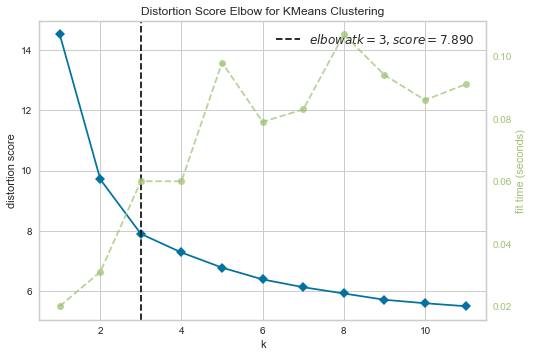

In [54]:
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans(england_grouped_clustering)
visualizer = KElbowVisualizer(model, k=(1,12))

visualizer.fit(england_grouped_clustering)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

It would seem that k=3 is the best number for clustering. This seems a bit strange as surely there must be more than 3 distinct types of English town. Therefore we will first try with a slighty higher number: k=5.

<H3>First try with K=5

In [58]:
# set number of clusters
kclusters = 5

#england_grouped_clustering = england_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=10, n_init=100,max_iter=100000, algorithm='full').fit(england_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ #[0:kclusters] 

array([0, 1, 2, 4, 0, 1, 4, 3, 0, 1, 2, 4, 3, 2, 3, 3, 4, 2, 0, 4, 4, 2,
       4, 4, 4, 2, 1, 4, 4, 1, 0, 1, 3, 4, 3, 4, 4, 4, 2, 3, 0, 3, 0, 4,
       2, 1, 2, 1, 4, 1, 2, 0, 0, 2, 2, 3, 2, 0, 0, 2, 0, 3, 0, 4, 3, 4,
       1, 4, 3, 2, 0, 1, 0, 1, 3, 0, 4, 2, 4, 0, 1, 4, 2, 3, 2, 1, 3, 4,
       2, 1, 4, 2, 1, 3, 2, 3, 1, 4, 0, 4, 1, 4, 2, 0, 4, 0, 2, 3, 3, 1,
       4, 2, 4, 2, 2, 1, 2, 1, 2, 2, 4, 0, 2, 4, 0, 1, 2, 3, 0, 1, 2, 4,
       4, 3, 3, 2, 1, 2, 1, 2, 1, 4, 2, 4, 2, 4, 1, 2, 4, 4, 3, 3, 2, 4,
       2, 4, 2, 2, 0, 0, 1, 2, 4, 2, 0, 1, 0, 0, 1, 4, 2, 1, 1, 4, 4, 2,
       2, 2, 0, 3, 0, 3, 4, 3, 2, 2, 4, 0, 2, 0, 1, 0, 0, 3, 2, 0, 1, 2,
       2, 3, 4, 3, 2, 4, 4, 0, 0, 1, 1, 3, 3, 3, 0, 4, 1, 4, 0, 2, 2, 4,
       1, 2, 3, 4, 2, 3, 1, 0, 0, 0, 2, 2, 4, 4, 4, 2, 0, 2, 2, 2, 2, 0,
       3, 2, 2, 3, 3, 3, 4, 2, 2, 2, 3, 3, 1, 3, 3, 3, 3, 4, 1, 3, 2, 0,
       0, 2, 4, 1, 2, 2, 4, 0, 2, 2, 4, 2, 2, 2, 3, 2, 2, 1, 0, 2, 2, 3,
       4, 2, 0, 0, 1, 0, 4, 2, 1, 2, 3, 2, 4, 0])

In [31]:
df_england_localities.rename(columns={'City/Town':'Neighbourhood'}, inplace=True)

E:\Programs\Anaconda\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [32]:
england_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Abingdon-on-Thames,20,20,20,20,20,20
Accrington,20,20,20,20,20,20
Aldershot,32,32,32,32,32,32
Aldridge,20,20,20,20,20,20
Altrincham,37,37,37,37,37,37
Andover,20,20,20,20,20,20
Arnold,20,20,20,20,20,20
Ashford,28,28,28,28,28,28
Ashton-under-Lyne,20,20,20,20,20,20


In [33]:
neighbourhoods_venues_sorted.set_index('Neighbourhood')

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighbourhood,,,,,,,,,,
Abingdon-on-Thames,Pub,Restaurant,Park,Station,Café,Pharmacy,Tea Room,Supermarket,Bakery,no_venue0
Accrington,Store,Café,Pub,Gym / Fitness Center,no_venue0,no_venue1,Movie Theater,Fast Food,Gym,Station
Aldershot,Store,Restaurant,Fast Food,Pub,Supermarket,Pharmacy,Café,Music Venue,Multiplex,Breakfast Spot
Aldridge,Fast Food,no_venue9,no_venue8,Restaurant,Café,Fish & Chips Shop,Store,Supermarket,no_venue0,no_venue1
Altrincham,Restaurant,Café,Bar,Store,Fast Food,Supermarket,Bookstore,Movie Theater,Pharmacy,Farmers Market
Andover,Store,no_venue9,Restaurant,Station,Supermarket,Fast Food,no_venue0,no_venue1,no_venue8,no_venue10
Arnold,Café,no_venue9,no_venue8,Fast Food,Store,Supermarket,Theater,no_venue0,no_venue1,no_venue10
Ashford,Store,Fast Food,Restaurant,Café,Supermarket,Pub,Station,Bowling Alley,Bookstore,Gym / Fitness Center
Ashton-under-Lyne,Restaurant,Pub,Fast Food,Café,Shopping Plaza,no_venue0,Gym,Movie Theater,Bowling Alley,Hotel


In [31]:
#use this line when re-running algorithm
#neighbourhoods_venues_sorted.drop(columns='Cluster Labels', inplace=True)

In [62]:
# add clustering labels

neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

england_merged = df_england_localities

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
england_merged = england_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

#england_merged.head() # check the last columns!

In [63]:
england_merged.head()

,Neighbourhood,Ceremonial county,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,London,London,51.507322,-0.127647,0,Restaurant,Bar,Hotel,Theater,Art,Fast Food,Store,Café,Pub,Plaza
1,Birmingham,West Midlands,52.479699,-1.902691,0,Restaurant,Bar,Café,Pub,Fast Food,Store,Hotel,Bistro,Plaza,Shopping Mall
2,Liverpool,Merseyside,53.407154,-2.991665,0,Restaurant,Hotel,Pub,Fast Food,Bar,Café,Store,Art,Station,Sporting Goods Shop
3,Bristol,Bristol,51.453802,-2.597298,0,Restaurant,Bar,Café,Fast Food,Pub,Art,Lounge,Music Venue,Theater,Frozen Yogurt Shop
4,Manchester,Greater Manchester,53.479489,-2.245115,0,Restaurant,Bar,Fast Food,Café,Hotel,Pub,Plaza,Concert Hall,Bakery,Bike Shop


In [64]:
#check we haven't got any unlabelled data
england_merged['Cluster Labels'].fillna(kclusters,inplace=True)
#england_merged[~england_merged['Cluster Labels'].isin([0,1,2,3,4])]
kclusters=kclusters+1

<H3>Show the results of clustering on a map of England

Differentiate localities by colour (representing cluster) and size (representing population)

In [120]:
import math

# create map
map_clusters = folium.Map(location=[52.4828, -1.6101], zoom_start=7)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(england_merged['latitude'], england_merged['longitude'], england_merged['Neighbourhood'], england_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    #change radius to reflect size of locality
    the_radius=int(math.sqrt((df_england[df_england["City/Town"]==poi]["Population"].iloc[0])/15000))
    folium.CircleMarker(
        [lat, lon],
        radius=the_radius,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<h3>Examination of the characteristics of the data clusters

The first cluster appears to contain big cities with a vibrant restaurant and coffee culture, perhaps with Art and Concert venues as well as some smaller towns with the same vibe.

In [66]:
england_merged.loc[england_merged['Cluster Labels'] == 0, england_merged.columns[[0] + list(range(5, england_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,London,Restaurant,Bar,Hotel,Theater,Art,Fast Food,Store,Café,Pub,Plaza
1,Birmingham,Restaurant,Bar,Café,Pub,Fast Food,Store,Hotel,Bistro,Plaza,Shopping Mall
2,Liverpool,Restaurant,Hotel,Pub,Fast Food,Bar,Café,Store,Art,Station,Sporting Goods Shop
3,Bristol,Restaurant,Bar,Café,Fast Food,Pub,Art,Lounge,Music Venue,Theater,Frozen Yogurt Shop
4,Manchester,Restaurant,Bar,Fast Food,Café,Hotel,Pub,Plaza,Concert Hall,Bakery,Bike Shop
5,Sheffield,Restaurant,Café,Pub,Bar,Fast Food,Store,Hotel,Theater,Station,Garden
6,Leeds,Restaurant,Bar,Café,Fast Food,Store,Pub,Shopping Mall,Indie Movie Theater,Chocolate Shop,Burrito Place
7,Leicester,Restaurant,Café,Bar,Fast Food,Store,Pub,Tea Room,Nightclub,Gastropub,Shopping Mall
10,Nottingham,Restaurant,Café,Bar,Fast Food,Pub,Store,Bookstore,Dessert Shop,Burrito Place,Tea Room
12,Newcastle upon Tyne,Restaurant,Bar,Café,Fast Food,Pub,Store,Bakery,Hotel,Nightclub,Lounge


The second cluster appears to be smaller "downmarket" towns with a mix of various shops, pubs and cafes and for which FourSquare has incomplete data

In [67]:
england_merged.loc[england_merged['Cluster Labels'] == 1, england_merged.columns[[0] + list(range(5, england_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Reading,Store,Pub,no_venue0,no_venue1,no_venue11,no_venue8,Art,no_venue9,no_venue10,no_venue3
43,Birkenhead,Store,Pub,Café,Station,Movie Theater,no_venue0,no_venue1,Plaza,Pool,Restaurant
61,Crawley,Store,no_venue9,no_venue8,Pub,Café,Breakfast Spot,Bookstore,no_venue0,no_venue1,no_venue10
63,Rotherham,Pub,Supermarket,no_venue1,no_venue0,Café,Fast Food,Bistro,Bookstore,Store,no_venue2
85,Hartlepool,Restaurant,Hotel,Stadium,Fast Food,Bar,Store,Theater,Movie Theater,no_venue0,no_venue1
113,Gosport,Store,Café,Supermarket,Restaurant,Fast Food,no_venue1,Park,Pharmacy,Harbor / Marina,Brewery
119,Lowestoft,Store,Pub,Café,Shopping Mall,Station,Bookstore,Fast Food,Pharmacy,no_venue0,no_venue1
120,Atherton,Pub,Supermarket,no_venue8,Roller Rink,Fast Food,Stadium,Store,no_venue0,no_venue1,no_venue10
130,Paignton,Pub,Bar,Café,Station,Hotel,Park,Supermarket,Stadium,Fish & Chips Shop,Sporting Goods Shop
131,Filton,Restaurant,Store,Pub,no_venue1,no_venue0,Sporting Goods Shop,no_venue8,Fast Food,Shopping Plaza,Hotel


The third category is made of slightly more upmarket towns with an interesting mix of various types of shops, restaurants and cafes.

In [68]:
england_merged.loc[england_merged['Cluster Labels'] == 2, england_merged.columns[[0] + list(range(5, england_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Coventry,Restaurant,Café,Store,Pub,Fast Food,Bar,Gym / Fitness Center,Pharmacy,Art,Bookstore
9,Bradford,Store,Restaurant,Café,Bar,Hotel,Fast Food,Art,Pub,Pharmacy,Movie Theater
11,Kingston upon Hull,Café,Store,Pub,Bar,Restaurant,Fast Food,Art,Station,Cosmetics Shop,Movie Theater
14,Southampton,Restaurant,Store,Café,Fast Food,Pub,Historic Site,Bookstore,Movie Theater,Dessert Shop,Creperie
15,Derby,Store,Restaurant,Café,Bar,Pub,Fast Food,Hotel,Lounge,Theater,Supermarket
18,Plymouth,Store,Café,Restaurant,Fast Food,Bookstore,Hotel,Pub,Chocolate Shop,Bar,Casino
22,Wolverhampton,Store,Café,Restaurant,Pub,Bar,Bakery,Fast Food,Cosmetics Shop,Casino,Pharmacy
23,Bolton,Store,Restaurant,Pub,Café,Pharmacy,Fast Food,Food & Drink Shop,Theater,Casino,Bar
28,Southend-on-Sea,Restaurant,Store,Café,Fast Food,Bar,Supermarket,Pharmacy,Multiplex,Bistro,Dessert Shop
30,Peterborough,Store,Restaurant,Fast Food,Café,Bar,Pub,Bookstore,Pharmacy,Shopping Mall,Station


The fourth category appears to be towns where the main attraction is an abundance of mainstream shops, complemented by fast food places, pubs and cafes

In [69]:
england_merged.loc[england_merged['Cluster Labels'] == 3, england_merged.columns[[0] + list(range(5, england_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,Swindon,Store,Café,Restaurant,Platform,Fast Food,Hotel,Pharmacy,Pub,Bookstore,Dessert Shop
27,Milton Keynes,Store,Café,Restaurant,Fast Food,Shopping Mall,Station,Optical Shop,Bookstore,Gym,Chocolate Shop
29,Middlesbrough,Store,Restaurant,Pub,Bar,Fast Food,Café,Hotel,Shopping Mall,Bookstore,Movie Theater
37,Poole,Store,Café,Station,Pharmacy,Pub,Plaza,Bus Stop,Fish & Chips Shop,Sporting Goods Shop,Gastropub
39,Telford,Store,Restaurant,Café,Shopping Plaza,Pharmacy,Supermarket,Bookstore,Fast Food,Hotel,Pub
51,Blackburn,Store,Café,Supermarket,Pub,Shopping Mall,Fast Food,Pharmacy,Concert Hall,Station,no_venue0
55,Salford,Store,Supermarket,Restaurant,Park,Fast Food,Pharmacy,Gym,Doctor's Office,Café,Mobile Phone Shop
57,Doncaster,Store,Pub,Café,Restaurant,Fast Food,Hotel,Bar,Pharmacy,Bookstore,Market
62,Rochdale,Store,Pub,Restaurant,no_venue0,Pharmacy,Shopping Mall,Bar,no_venue1,Fast Food,no_venue2
64,Stockport,Store,Café,Pub,Pharmacy,Bookstore,Fast Food,Brewery,Restaurant,Farmers Market,Movie Theater


The final category encompasses towns where inexplicably there is very little FourSquare data. This inclues large towns such as Portsmouth, Luton and Blackpool which certainly don't lack in venues!

In [70]:
england_merged.loc[england_merged['Cluster Labels'] == 4, england_merged.columns[[0] + list(range(5, england_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Stoke-on-Trent,no_venue9,no_venue15,Park,no_venue8,Pharmacy,Volleyball Court,no_venue1,no_venue10,no_venue11,no_venue12
16,Portsmouth,Restaurant,no_venue9,no_venue15,Store,Fast Food,no_venue8,no_venue1,no_venue10,no_venue11,no_venue12
21,Luton,no_venue9,no_venue14,Store,Park,Fast Food,Gym / Fitness Center,no_venue8,no_venue1,no_venue10,no_venue11
32,Warrington,no_venue9,no_venue14,Park,Pub,Bar,no_venue8,Restaurant,no_venue1,no_venue10,no_venue11
34,Slough,no_venue9,no_venue15,Business Service,no_venue8,Cosmetics Shop,no_venue1,no_venue10,no_venue11,no_venue12,no_venue13
42,Blackpool,no_venue9,no_venue14,Bus Stop,Store,Supermarket,no_venue8,Restaurant,no_venue1,no_venue10,no_venue11
56,Basildon,Store,no_venue9,Restaurant,no_venue8,no_venue0,no_venue10,no_venue11,no_venue12,no_venue13,no_venue14
88,Grimsby,Store,no_venue9,no_venue13,Supermarket,Shopping Plaza,no_venue8,no_venue0,no_venue10,no_venue11,no_venue12
97,Bracknell,Restaurant,no_venue9,no_venue14,Fish & Chips Shop,Store,Pub,no_venue8,no_venue1,no_venue10,no_venue11
99,Batley,Restaurant,Supermarket,no_venue9,Bakery,no_venue8,no_venue1,no_venue10,no_venue11,no_venue12,no_venue13


<H3>Results of K-means where K=3

In [29]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=10, n_init=100,max_iter=100000, algorithm='full').fit(england_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ #[0:kclusters]

array([1, 0, 0, 2, 1, 2, 2, 0, 1, 2, 0, 2, 0, 0, 0, 0, 2, 0, 1, 2, 2, 1,
       2, 2, 2, 1, 1, 2, 2, 0, 1, 1, 0, 2, 0, 2, 2, 2, 0, 0, 1, 0, 1, 2,
       0, 2, 1, 1, 2, 2, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 2, 0, 2,
       2, 2, 0, 0, 1, 2, 1, 2, 0, 1, 2, 0, 2, 1, 2, 2, 1, 0, 1, 2, 0, 2,
       0, 1, 2, 1, 2, 0, 0, 0, 2, 2, 1, 2, 2, 2, 0, 1, 2, 1, 0, 0, 0, 2,
       2, 0, 2, 0, 0, 2, 0, 0, 0, 1, 2, 1, 0, 2, 1, 1, 0, 0, 1, 2, 0, 2,
       2, 0, 0, 0, 1, 0, 0, 1, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 0, 0, 2,
       0, 2, 1, 1, 1, 1, 1, 0, 2, 1, 1, 2, 1, 1, 0, 2, 0, 2, 0, 2, 2, 0,
       1, 0, 1, 0, 1, 0, 2, 0, 0, 1, 2, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 2, 0, 0, 2, 2, 1, 1, 2, 2, 0, 0, 0, 1, 2, 2, 2, 1, 0, 0, 2,
       0, 0, 0, 2, 0, 0, 2, 1, 1, 1, 1, 0, 2, 2, 2, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 1, 1,
       1, 0, 2, 2, 0, 0, 2, 1, 1, 1, 2, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       2, 1, 1, 1, 2, 1, 2, 0, 2, 1, 0, 0, 2, 1])

In [35]:
#uncomment when re-running!
#neighbourhoods_venues_sorted.drop(columns='Cluster Labels', inplace=True)

In [36]:
# add clustering labels

neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

england_merged = df_england_localities

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
england_merged = england_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

#england_merged.head() # check the last columns!

In [37]:
england_merged['Cluster Labels'].fillna(kclusters,inplace=True)
#england_merged[~england_merged['Cluster Labels'].isin([0,1,2,3,4])]
kclusters=kclusters+1

In [45]:
import math

# create map
map_clusters = folium.Map(location=[52.4828, -1.6101], zoom_start=7)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
rainbow=['blue','yellow','red']
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(england_merged['latitude'], england_merged['longitude'], england_merged['Neighbourhood'], england_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    #change radius to reflect size of locality
    the_radius=int(math.sqrt((df_england[df_england["City/Town"]==poi]["Population"].iloc[0])/15000))
    folium.CircleMarker(
        [lat, lon],
        radius=the_radius,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The first category appears to be towns where the main attraction is an abundance of mainstream shops, complemented by fast food places, pubs and cafes

In [46]:
england_merged.loc[england_merged['Cluster Labels'] == 0, england_merged.columns[[0] + list(range(5, england_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Bradford,Store,Bar,Café,Restaurant,Hotel,Fast Food,Pub,Plaza,Pharmacy,Movie Theater
11,Kingston upon Hull,Café,Store,Pub,Bar,Fast Food,Restaurant,Bookstore,Art,Station,Cosmetics Shop
18,Plymouth,Store,Café,Restaurant,Fast Food,Hotel,Pub,Chocolate Shop,Bar,Bookstore,Ice Cream Shop
22,Wolverhampton,Store,Café,Restaurant,Pub,Bar,Fast Food,Bakery,Rock Club,Casino,Comic Shop
23,Bolton,Store,Restaurant,Pub,Café,Pharmacy,Fast Food,Gastropub,Station,Business Service,Food & Drink Shop
26,Swindon,Store,Café,Restaurant,Platform,Hotel,Fast Food,Pub,Bookstore,Pharmacy,Gym
27,Milton Keynes,Store,Café,Restaurant,Fast Food,Bookstore,Shopping Mall,Station,Optical Shop,Deli / Bodega,Donut Shop
28,Southend-on-Sea,Restaurant,Store,Café,Fast Food,Supermarket,Bar,Pharmacy,Dessert Shop,Pub,Bakery
29,Middlesbrough,Store,Restaurant,Pub,Bar,Shopping Mall,Fast Food,Café,Bookstore,Hotel,Park
30,Peterborough,Store,Restaurant,Fast Food,Café,Bar,Pub,Hotel,Bookstore,Station,Shopping Mall


The second cluster appears to contain big cities with a vibrant restaurant and coffee culture, perhaps with Art and Concert venues as well as some smaller towns with the same vibe.

In [47]:
england_merged.loc[england_merged['Cluster Labels'] == 1, england_merged.columns[[0] + list(range(5, england_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,London,Restaurant,Bar,Hotel,Theater,Fast Food,Art,Store,Café,Pub,Ice Cream Shop
1,Birmingham,Restaurant,Bar,Café,Pub,Fast Food,Store,Hotel,Bistro,Shopping Mall,Plaza
2,Liverpool,Restaurant,Hotel,Pub,Fast Food,Bar,Café,Store,Art,Outdoor Sculpture,Movie Theater
3,Bristol,Restaurant,Bar,Café,Fast Food,Pub,Art,Market,Lounge,Gastropub,Theater
4,Manchester,Restaurant,Bar,Fast Food,Café,Hotel,Pub,Plaza,Concert Hall,Bakery,Theater
5,Sheffield,Restaurant,Café,Bar,Pub,Store,Fast Food,Hotel,Theater,Plaza,Garden
6,Leeds,Restaurant,Bar,Café,Fast Food,Store,Pub,Shopping Mall,Road,Bookstore,Speakeasy
7,Leicester,Restaurant,Café,Bar,Fast Food,Store,Pub,Shopping Mall,Deli / Bodega,Gastropub,Tea Room
8,Coventry,Restaurant,Café,Store,Pub,Fast Food,Gym / Fitness Center,Bar,Pharmacy,Bookstore,Art
10,Nottingham,Restaurant,Café,Bar,Fast Food,Pub,Store,Bookstore,Dessert Shop,Burrito Place,Nightclub


The final category encompasses towns where inexplicably there is very little FourSquare data. This inclues large towns such as Portsmouth, Luton and Blackpool which certainly don't lack in venues!

In [48]:
england_merged.loc[england_merged['Cluster Labels'] == 2, england_merged.columns[[0] + list(range(5, england_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Stoke-on-Trent,no_venue9,no_venue15,Park,no_venue8,Bakery,Restaurant,no_venue1,no_venue10,no_venue11,no_venue12
16,Portsmouth,Store,no_venue9,no_venue15,Fast Food,no_venue8,Restaurant,no_venue1,no_venue10,no_venue11,no_venue12
20,Reading,Pub,Store,Art,Restaurant,Fish Market,no_venue0,no_venue1,no_venue10,no_venue8,no_venue9
21,Luton,no_venue9,no_venue14,Fast Food,Store,Park,no_venue8,Gym / Fitness Center,no_venue1,no_venue10,no_venue11
32,Warrington,no_venue9,no_venue15,Park,Bar,no_venue8,no_venue1,no_venue10,no_venue11,no_venue12,no_venue13
34,Slough,no_venue9,no_venue15,Bus Stop,Cosmetics Shop,Bed & Breakfast,no_venue8,no_venue1,no_venue10,no_venue11,no_venue12
42,Blackpool,no_venue9,no_venue14,Pub,Restaurant,Store,no_venue8,no_venue0,no_venue1,no_venue10,no_venue11
56,Basildon,Store,no_venue9,no_venue15,Fast Food,no_venue8,Restaurant,no_venue1,no_venue10,no_venue11,no_venue12
61,Crawley,Store,no_venue9,no_venue8,Café,Skate Park,Breakfast Spot,Theater,no_venue0,no_venue1,no_venue10
63,Rotherham,Pub,Café,Supermarket,Bar,no_venue6,no_venue5,no_venue4,no_venue3,no_venue2,Store
